In [1]:
'''

#Enable GPU for this Exercise.

'''



'\n\n#Enable GPU for this Exercise.\n\n'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import numpy as np
from filelock import FileLock
import os
from functools import partial

from ray import train, tune
from ray.air import session

# This package is helpful to apply noise to our images
import skimage

#If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'


transformations = transforms.Compose([transforms.ToTensor()])

'''
Import Mnist
'''

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transformations)

mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transformations)

'''
Normalize each input from [0.0,1.0] range
'''
x_train = mnist_train.data.float() / 255.
x_test = mnist_test.data.float() / 255.

'''
Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)


In [3]:
# create your training sets (X_train_GN) and (X_train_SP)

# Add salt and pepper noise to the training set
X_train_SP = skimage.util.random_noise(x_train, mode='s&p', clip=True, amount=0.1)

# Add Gaussian Noise to the training set
X_train_GN = skimage.util.random_noise(x_train, mode='gaussian', clip=True)



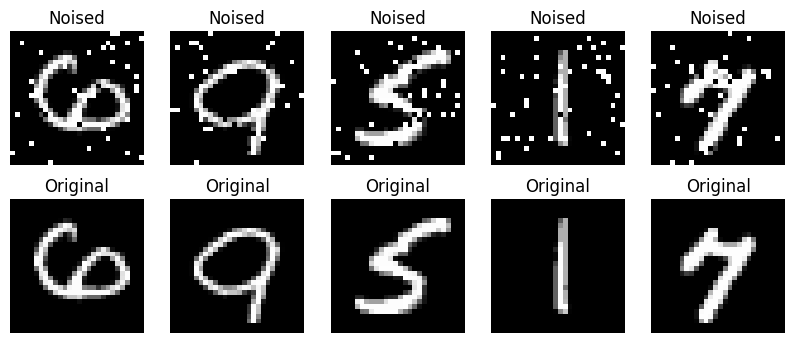

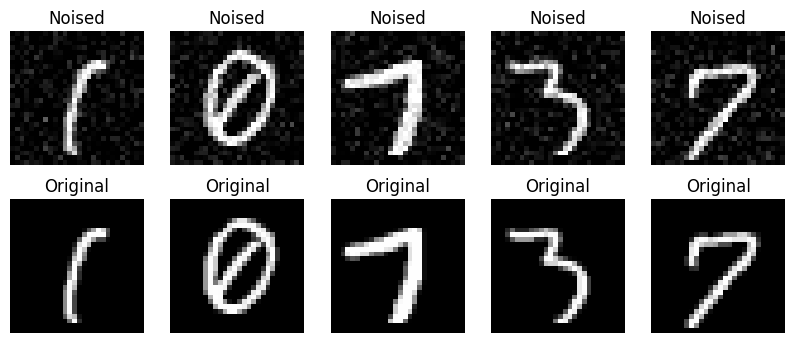

In [4]:
def plot_first_k(noised, original, k=5, labels=['Noised', 'Original']):
    fig, ax = plt.subplots(2, k, figsize=(2*k, 4))
    for i, im in enumerate(np.random.choice(len(noised), k)):
        ax[0, i].imshow(noised[im].reshape(28, 28), cmap='gray')
        ax[1, i].imshow(original[im].reshape(28, 28), cmap='gray')
        ax[0, i].set_title(labels[0])
        ax[1, i].set_title(labels[1])
        ax[0, i].axis('off')
        ax[1, i].axis('off')
    plt.show()

plot_first_k(X_train_SP, x_train)
plot_first_k(X_train_GN, x_train)


In [14]:
'''
Create the architecture 

'''

class Autoencoder(nn.Module):
    def __init__(self, in_channels=1, size=(28, 28), channels = [16, 8]):
        super(Autoencoder, self).__init__()

        # Calculating output size from convolutions
        self.H_in = size[0]
        self.W_in = size[1]
        self.channel_1 = channels[0]
        self.channel_2 = channels[1]
        padding = 0
        dilation = 1
        stride_conv = 1
        kernel_conv = 5
        stride_pool = 2
        kernel_pool = 2

        self.H_conv_1 = int((self.H_in + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)
        self.W_conv_1 = int((self.W_in + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)

        self.H_pool_1 = int((self.H_conv_1 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)
        self.W_pool_1 = int((self.W_conv_1 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)

        self.H_conv_2 = int((self.H_pool_1 + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)
        self.W_conv_2 = int((self.W_pool_1 + 2*padding - dilation*(kernel_conv - 1) - 1)/stride_conv + 1)

        self.H_pool_2 = int((self.H_conv_2 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)
        self.W_pool_2 = int((self.W_conv_2 + 2*padding - dilation*(kernel_pool - 1) - 1)/stride_pool + 1)

        final_size = int(self.H_pool_2*self.W_pool_2*self.channel_2)


        ## Encoder
        self.encoder_relu = nn.ReLU()
        self.encoder_sig = nn.Sigmoid()

        self.encoder_conv1 = nn.Conv2d(in_channels, channels[0], kernel_size=(5, 5), bias=False)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True)
        self.encoder_conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=(5, 5), bias=False)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), return_indices=True)
        self.encoder_flatten = nn.Flatten()
        self.encoder_lin1 = nn.Linear(final_size, 256)
        self.encoder_lin2 = nn.Linear(256, 128)
        self.encoder_lin3 = nn.Linear(128, 50)

        ## Decoder
        # First Linear Layer
        self.decode_lin1 = nn.Linear(50, 128)
        self.decode_sig = nn.Sigmoid()
        # Second Linear Layer
        self.decode_lin2 = nn.Linear(128, 256)
        # Third Linear Layer
        self.decode_lin3 = nn.Linear(256, final_size)
        
        self.unflat = nn.Unflatten(1, (channels[1], int(self.H_pool_2), int(self.W_pool_2)))

        # First Transposed Convolutional Layer
        self.decode_unpool = nn.MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2))
        self.decode_unconv = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=(5, 5), bias=False)
        self.relu = nn.ReLU()
        # Second Transposed Convolutional Layer
        self.decode_unconv2 = nn.ConvTranspose2d(channels[0], in_channels, kernel_size=(5, 5), bias=False)


    def forward(self, x):
        # Encoder Pass
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        x = self.encoder_relu(x)
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)
        x = self.encoder_relu(x)
        x = self.encoder_flatten(x)
        x = self.encoder_lin1(x)
        x = self.encoder_sig(x)
        x = self.encoder_lin2(x)
        x = self.encoder_sig(x)
        x = self.encoder_lin3(x)
        x = self.encoder_sig(x)


        x = self.decode_lin1(x)
        x = self.decode_sig(x)
        x = self.decode_lin2(x)
        x = self.decode_sig(x)
        x = self.decode_lin3(x)
        x = self.decode_sig(x)
        x = self.unflat(x)
        x = self.decode_unpool(x, indices2, output_size=(x.shape[0], self.channel_2, self.H_conv_2, self.W_conv_2))
        x = self.decode_unconv(x)
        x = self.relu(x)
        x = self.decode_unpool(x, indices1, output_size=(x.shape[0], self.channel_1, self.H_conv_1, self.W_conv_1))
        x = self.decode_unconv2(x)
        x = self.relu(x)

        return x

In [6]:
'''
Define your training routine,
your optimizer, your loss function.
Everything you need to train the model
'''
def train_single(model, dataloader_train, dataloader_valid, epochs, criterion, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for epoch in range(epochs):
        train_losses = []
        model.train()
        for data in dataloader_train:
            img, target = data
            img, target = img.to(device), target.to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, target)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        valid_losses = []
        with torch.no_grad():
            model.eval()
            for data in dataloader_valid:
                img, target = data
                img, target = img.to(device), target.to(device)
                # ===================forward=====================
                output = model(img)
                loss = criterion(output, target)
                valid_losses.append(loss.item())

        # ===================log========================
        mean_train_loss = torch.mean(torch.tensor(train_losses)).detach().cpu().numpy()
        mean_valid_loss = torch.mean(torch.tensor(valid_losses)).detach().cpu().numpy()
        print('epoch [{:3d}/{:3d}], Train Loss:{:.4f} | Validation Loss {:.4f}'.format(epoch + 1, epochs, mean_train_loss, mean_valid_loss))

    return (mean_train_loss, mean_valid_loss)

data_dir = os.path.abspath("./data")

def load_data():
    print('Loading data from: ', data_dir)
    trainset = datasets.MNIST(
                root=data_dir, train=True, download=True, transform=transformations)
    print('Data loaded.')
    return trainset




In [12]:
# Finding good hyper parameters for the model
def train_auto(config, data_dir=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_data = load_data()
    x_train = (train_data.data.float() / 255.).reshape(-1, 1, 28, 28)
    x_train_sp = skimage.util.random_noise(x_train, mode='s&p', clip=True, amount=0.1)

    sp_dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train_sp)[:30_000], x_train[:30_000])
    sp_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(x_train_sp)[30_000:], x_train[30_000:])

    sp_dataloader_train = torch.utils.data.DataLoader(sp_dataset_train, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
    sp_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

    model = Autoencoder(channels=config['channels']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    train_valid_loss = train_single(model, sp_dataloader_train, sp_dataloader_valid, 50, criterion, optimizer)
    train.report({'train_loss': train_valid_loss[0], 'valid_loss': train_valid_loss[1]})

search_space = {
    "lr": tune.grid_search([0.001, 0.0001]),
    'channels': tune.grid_search([[16, 8], [32, 16], [64, 32]])
}

trainable_with_resource = tune.with_resources(train_auto, {'cpu': 10, 'gpu': 1})

tuner = tune.Tuner(
    trainable_with_resource,
    param_space=search_space
)

results = tuner.fit()
print(results)

(train_auto pid=657576) Loading data from:  /home/codygrogan/Classes/DeepLearningTheory/HW-5/data
(train_auto pid=657576) Data loaded.
(train_auto pid=657576) epoch [  1/ 50], Train Loss:0.0447 | Validation Loss 0.0287
(train_auto pid=657576) epoch [  2/ 50], Train Loss:0.0202 | Validation Loss 0.0160
(train_auto pid=657576) epoch [  3/ 50], Train Loss:0.0150 | Validation Loss 0.0140
(train_auto pid=657576) epoch [  4/ 50], Train Loss:0.0134 | Validation Loss 0.0130
(train_auto pid=657576) epoch [  5/ 50], Train Loss:0.0127 | Validation Loss 0.0124
(train_auto pid=657576) epoch [  6/ 50], Train Loss:0.0123 | Validation Loss 0.0121
(train_auto pid=657576) epoch [  7/ 50], Train Loss:0.0120 | Validation Loss 0.0119
(train_auto pid=657576) epoch [  8/ 50], Train Loss:0.0118 | Validation Loss 0.0117
(train_auto pid=657576) epoch [  9/ 50], Train Loss:0.0116 | Validation Loss 0.0115
(train_auto pid=657576) epoch [ 10/ 50], Train Loss:0.0114 | Validation Loss 0.0112
(train_auto pid=657576) e

2023-11-12 15:25:00,070	INFO tune.py:1047 -- Total run time: 301.70 seconds (301.68 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'train_loss': array(0.00947594, dtype=float32), 'valid_loss': array(0.00947164, dtype=float32)},
    path='/home/codygrogan/ray_results/train_auto_2023-11-12_15-19-58/train_auto_9d507_00000_0_channels=16_8,lr=0.0010_2023-11-12_15-19-58',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_loss': array(0.00748725, dtype=float32), 'valid_loss': array(0.00758469, dtype=float32)},
    path='/home/codygrogan/ray_results/train_auto_2023-11-12_15-19-58/train_auto_9d507_00001_1_channels=32_16,lr=0.0010_2023-11-12_15-19-58',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_loss': array(0.00606487, dtype=float32), 'valid_loss': array(0.00636774, dtype=float32)},
    path='/home/codygrogan/ray_results/train_auto_2023-11-12_15-19-58/train_auto_9d507_00002_2_channels=64_32,lr=0.0010_2023-11-12_15-19-58',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_loss': array(0.01128452, 

In [15]:
# define the netowrk to be train with the salt and peper corrupted images
# train the network
AutoNN_SP = Autoencoder(channels=[64, 32]).to(device)

sp_dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train_SP)[:30_000], x_train[:30_000])
sp_dataloader_train = torch.utils.data.DataLoader(sp_dataset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

sp_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(X_train_SP)[30_000:], x_train[30_000:])
sp_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(AutoNN_SP.parameters(), lr=0.001)

train_valid_loss = train_single(AutoNN_SP, sp_dataloader_train, sp_dataloader_valid, 25, criterion, optimizer)




epoch [  1/ 25], Train Loss:0.0223 | Validation Loss 0.0137
epoch [  2/ 25], Train Loss:0.0108 | Validation Loss 0.0094
epoch [  3/ 25], Train Loss:0.0089 | Validation Loss 0.0084
epoch [  4/ 25], Train Loss:0.0081 | Validation Loss 0.0079
epoch [  5/ 25], Train Loss:0.0078 | Validation Loss 0.0076
epoch [  6/ 25], Train Loss:0.0075 | Validation Loss 0.0074
epoch [  7/ 25], Train Loss:0.0073 | Validation Loss 0.0072
epoch [  8/ 25], Train Loss:0.0071 | Validation Loss 0.0071
epoch [  9/ 25], Train Loss:0.0069 | Validation Loss 0.0070
epoch [ 10/ 25], Train Loss:0.0068 | Validation Loss 0.0070
epoch [ 11/ 25], Train Loss:0.0067 | Validation Loss 0.0068
epoch [ 12/ 25], Train Loss:0.0067 | Validation Loss 0.0067
epoch [ 13/ 25], Train Loss:0.0066 | Validation Loss 0.0067
epoch [ 14/ 25], Train Loss:0.0065 | Validation Loss 0.0070
epoch [ 15/ 25], Train Loss:0.0065 | Validation Loss 0.0066
epoch [ 16/ 25], Train Loss:0.0064 | Validation Loss 0.0066
epoch [ 17/ 25], Train Loss:0.0064 | Val

In [17]:
# define the netowrk to be train with the gaussian corrupted images
# train the network 
AutoNN_GN = Autoencoder(channels=[64,32]).to(device)

gn_dataset_train = torch.utils.data.TensorDataset(torch.tensor(X_train_GN)[:30_000], x_train[:30_000])
gn_dataloader_train = torch.utils.data.DataLoader(gn_dataset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

gn_dataset_valid = torch.utils.data.TensorDataset(torch.tensor(X_train_GN)[30_000:], x_train[30_000:])
gn_dataloader_valid = torch.utils.data.DataLoader(sp_dataset_valid, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(AutoNN_GN.parameters(), lr=0.001)

train_valid_loss = train_single(AutoNN_GN, sp_dataloader_train, sp_dataloader_valid, 25, criterion, optimizer)


epoch [  1/ 50], Train Loss:0.0220 | Validation Loss 0.0121
epoch [  2/ 50], Train Loss:0.0104 | Validation Loss 0.0092
epoch [  3/ 50], Train Loss:0.0087 | Validation Loss 0.0082
epoch [  4/ 50], Train Loss:0.0081 | Validation Loss 0.0078
epoch [  5/ 50], Train Loss:0.0076 | Validation Loss 0.0076
epoch [  6/ 50], Train Loss:0.0074 | Validation Loss 0.0073
epoch [  7/ 50], Train Loss:0.0072 | Validation Loss 0.0072
epoch [  8/ 50], Train Loss:0.0070 | Validation Loss 0.0071
epoch [  9/ 50], Train Loss:0.0069 | Validation Loss 0.0070
epoch [ 10/ 50], Train Loss:0.0068 | Validation Loss 0.0070
epoch [ 11/ 50], Train Loss:0.0068 | Validation Loss 0.0069
epoch [ 12/ 50], Train Loss:0.0067 | Validation Loss 0.0070
epoch [ 13/ 50], Train Loss:0.0066 | Validation Loss 0.0067
epoch [ 14/ 50], Train Loss:0.0066 | Validation Loss 0.0067
epoch [ 15/ 50], Train Loss:0.0065 | Validation Loss 0.0066
epoch [ 16/ 50], Train Loss:0.0065 | Validation Loss 0.0066
epoch [ 17/ 50], Train Loss:0.0065 | Val

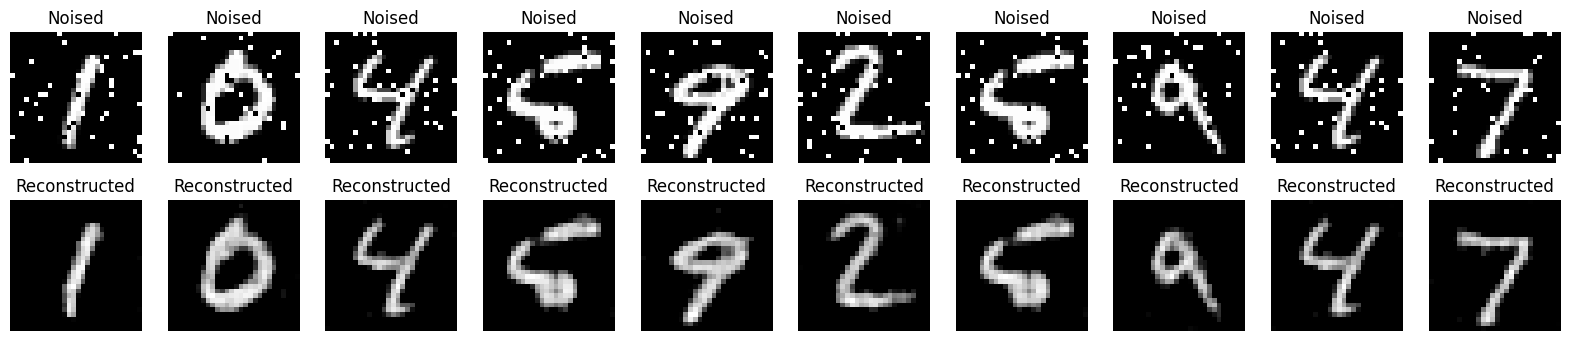

In [16]:
# corrupt test images with Salt and peper, pass them through AutoNN_SP 
# plot the results 

x_test_sp = torch.tensor(skimage.util.random_noise(x_test[:10], mode='s&p', clip=True, amount=0.1)).to(device)
output = AutoNN_SP(x_test_sp)
output = output.detach().cpu().numpy()

plot_first_k(x_test_sp.detach().cpu().numpy(), output, k=10, labels=['Noised', 'Reconstructed'])


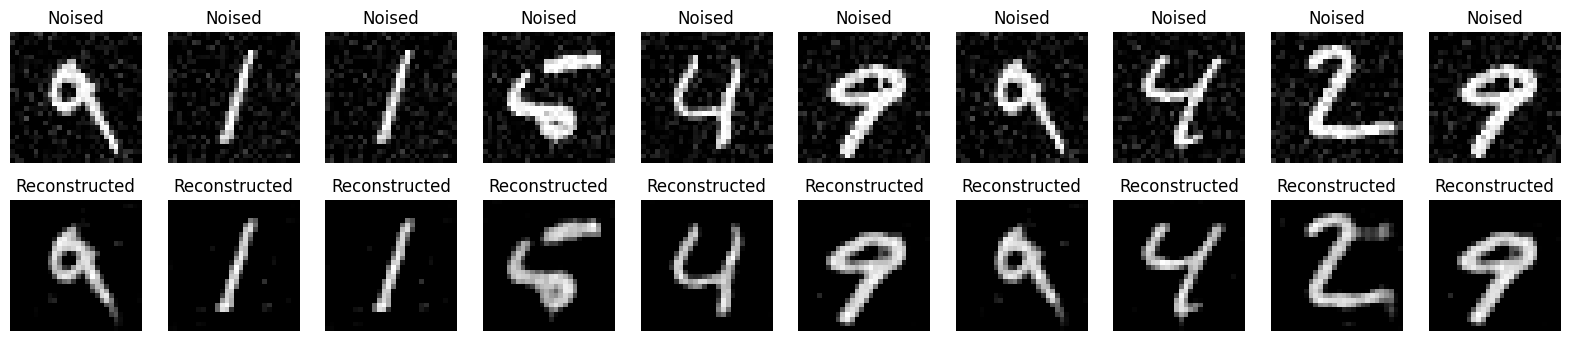

In [18]:
# corrupt test images with Gaussian noise, pass them through AutoNN_GN
# plot the results 

x_test_gn = torch.tensor(skimage.util.random_noise(x_test[:10], mode='gaussian', clip=True), dtype=torch.float32).to(device)
output = AutoNN_GN(x_test_gn)
output = output.detach().cpu().numpy()

plot_first_k(x_test_gn.detach().cpu().numpy(), output, k=10, labels=['Noised', 'Reconstructed'])